In [37]:
import warnings
warnings.filterwarnings('ignore')

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sklearn.model_selection import GroupShuffleSplit

# Import Data and Clean

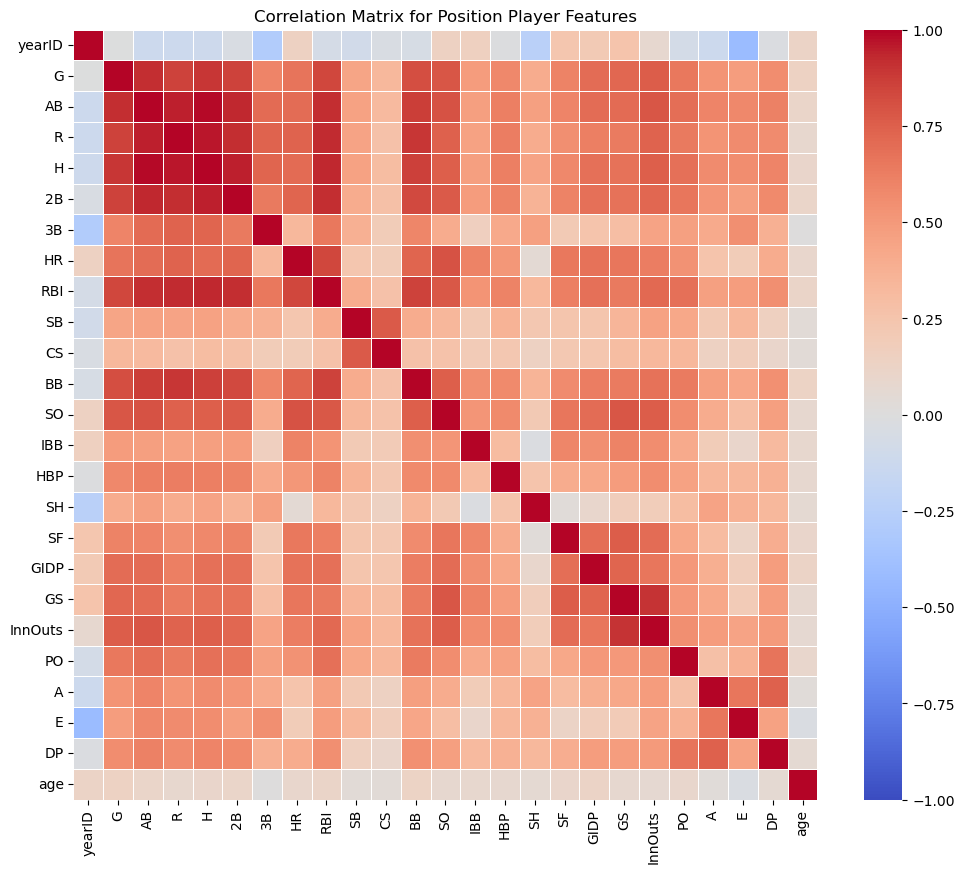

In [40]:
# Load data with specified file paths
fielding = pd.read_csv('Fielding.csv')
batting = pd.read_csv('Batting.csv')
pitching = pd.read_csv('Pitching.csv')
savant_pitch_data = pd.read_csv('savant_pitch_data.csv')
players = pd.read_csv('People.csv', encoding='latin1')

# Ensure 'playerID' is of the same type (string) across all dataframes
fielding['playerID'] = fielding['playerID'].astype(str)
batting['playerID'] = batting['playerID'].astype(str)
pitching['playerID'] = pitching['playerID'].astype(str)
savant_pitch_data['player_id'] = savant_pitch_data['player_id'].astype(str)

# Rename 'player_id' in Savant data to match 'playerID'
savant_pitch_data.rename(columns={'player_id': 'playerID'}, inplace=True)

# Filter relevant columns for each dataset
# Pitching-specific columns
pitching_cols = [
    'playerID', 'yearID', 'stint', 'W', 'L', 'G', 'GS', 'CG', 'SHO', 'SV', 
    'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp', 'ERA', 'WP', 'BK', 'BFP', 'GF'
]

# Combine batting and fielding columns for position players
batting_cols = [
    'playerID', 'yearID', 'stint', 'G', 'AB', 'R', 'H', '2B', '3B', 'HR', 
    'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP'
]
fielding_cols = [
    'playerID', 'yearID', 'stint', 'G', 'GS', 'InnOuts', 'PO', 'A', 
    'E', 'DP', 'PB', 'WP', 'SB', 'CS', 'ZR'
]

# Filter each dataset to keep only relevant columns
pitching = pitching[pitching_cols]
batting = batting[[col for col in batting_cols if col in batting.columns]]
fielding = fielding[[col for col in fielding_cols if col in fielding.columns]]

# Merge batting and fielding data to form a combined position player dataset
position_players = pd.merge(batting, fielding, on=['playerID', 'yearID', 'stint', 'G'], how='outer')

# Add birth year for age calculation to both datasets
players = players[['playerID', 'birthYear']]

# Merge position player stats with player info to calculate age
position_players = pd.merge(position_players, players, on='playerID', how='left')
position_players['age'] = position_players['yearID'] - position_players['birthYear']
position_players.drop(columns=['birthYear'], inplace=True)

# Define a function to handle duplicate columns SB and CS
def choose_column(sb_x, sb_y):
    return sb_x if not pd.isna(sb_x) else sb_y

def choose_cs(cs_x, cs_y):
    return cs_x if not pd.isna(cs_x) else cs_y

# Apply the logic to aggregate and remove duplicate SB and CS columns
position_players_grouped = (
    position_players
    .assign(
        SB=lambda df: df.apply(lambda row: choose_column(row['SB_x'], row['SB_y']), axis=1),
        CS=lambda df: df.apply(lambda row: choose_cs(row['CS_x'], row['CS_y']), axis=1)
    )
    .drop(columns=['SB_x', 'SB_y', 'CS_x', 'CS_y'])  # Remove the duplicate columns
    .groupby(['playerID', 'yearID'])
    .agg({
        'G': 'sum',  # Sum games played
        'AB': 'sum',  # Sum at-bats
        'R': 'sum',  # Sum runs
        'H': 'sum',  # Sum hits
        '2B': 'sum',  # Sum doubles
        '3B': 'sum',  # Sum triples
        'HR': 'sum',  # Sum home runs
        'RBI': 'sum',  # Sum runs batted in
        'SB': 'sum',  # Sum chosen SB
        'CS': 'sum',  # Sum chosen CS
        'BB': 'sum',  # Sum walks
        'SO': 'sum',  # Sum strikeouts
        'IBB': 'sum',  # Sum intentional walks
        'HBP': 'sum',  # Sum hit by pitches
        'SH': 'sum',  # Sum sacrifice hits
        'SF': 'sum',  # Sum sacrifice flies
        'GIDP': 'sum',  # Sum grounded into double plays
        'GS': 'sum',  # Sum games started (fielding)
        'InnOuts': 'sum',  # Sum innings played (fielding)
        'PO': 'sum',  # Sum putouts
        'A': 'sum',  # Sum assists
        'E': 'sum',  # Sum errors
        'DP': 'sum',  # Sum double plays
        'age': 'first'  # Keep the player's age for that season
    })
    .reset_index()  # Reset the index for a clean dataframe
)


position_players_grouped.to_csv('position_players.csv', index=False)

# correlation matrix 
numeric_cols = position_players_grouped.select_dtypes(include=['number']).columns
corr_matrix = position_players_grouped[numeric_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix for Position Player Features')
plt.show()

# Merge pitching stats with player info to calculate age
pitchers = pd.merge(pitching, players, on='playerID', how='left')
pitchers['age'] = pitchers['yearID'] - pitchers['birthYear']
pitchers.drop(columns=['birthYear'], inplace=True)

pitchers.to_csv('pitchers_dataframe.csv')

## Feature Selection


Position Players - Selected Features:
Index(['yearID', 'G', 'AB', 'R', 'H', '2B', '3B', 'RBI', 'BB', 'SO', 'HBP',
       'GS', 'InnOuts', 'PO', 'DP'],
      dtype='object')


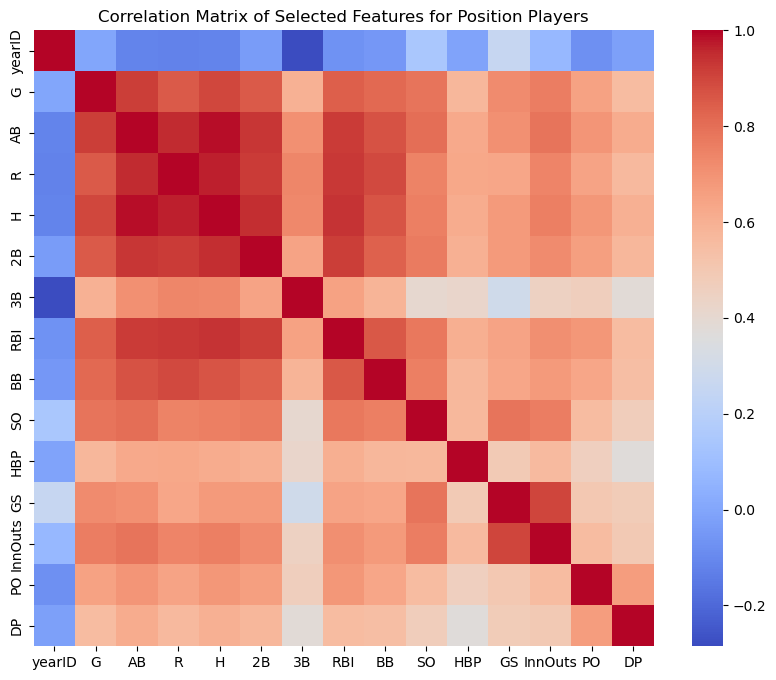


Pitchers - Selected Features:
Index(['yearID', 'stint', 'W', 'L', 'GS', 'CG', 'SHO', 'SV', 'IPouts', 'H',
       'ER', 'ERA', 'BK', 'BFP', 'GF'],
      dtype='object')


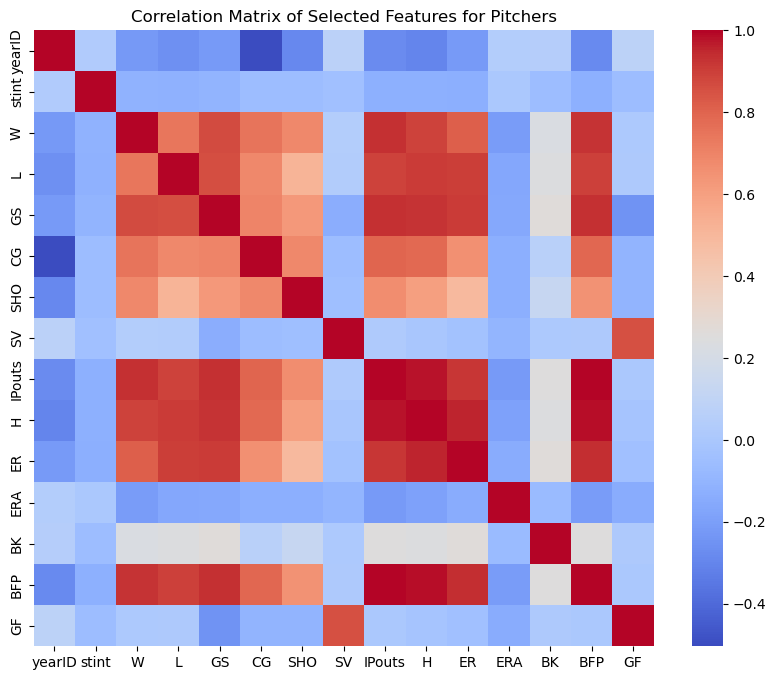

In [101]:
# Feature Selection for Position Players
if not position_players_grouped.empty:
    # Fill NaN values with 0 or mean to avoid dropping columns
    X_pos = position_players_grouped.select_dtypes(include=[np.number]).fillna(0)  # Fills NaNs with 0

    # Perform feature selection with a random target
    selector_pos = SelectKBest(score_func=f_regression, k=15)
    selector_pos.fit(X_pos, np.random.rand(len(X_pos)))  # Use random target as placeholder
    selected_features_pos = X_pos.columns[selector_pos.get_support(indices=True)]

    print("\nPosition Players - Selected Features:")
    print(selected_features_pos)

    #Plot correlation matrix of selected features for position players
    plt.figure(figsize=(10, 8))
    sns.heatmap(X_pos[selected_features_pos].corr(), annot=False, cmap="coolwarm", cbar=True)
    plt.title("Correlation Matrix of Selected Features for Position Players")
    plt.show()


# Feature Selection for Pitchers
if not pitchers.empty:
    # Fill NaN values with 0 to avoid dropping columns
    X_pitch = pitchers.select_dtypes(include=[np.number]).fillna(0)

    # Perform feature selection with a random target
    selector_pitch = SelectKBest(score_func=f_regression, k=15)
    selector_pitch.fit(X_pitch, np.random.rand(len(X_pitch)))  # Use random target as placeholder
    selected_features_pitch = X_pitch.columns[selector_pitch.get_support(indices=True)]

    print("\nPitchers - Selected Features:")
    print(selected_features_pitch)

    # Plot correlation matrix of selected features for pitchers
    plt.figure(figsize=(10, 8))
    sns.heatmap(X_pitch[selected_features_pitch].corr(), annot=False, cmap="coolwarm", cbar=True)
    plt.title("Correlation Matrix of Selected Features for Pitchers")
    plt.show()

## Filtering the Data

In [45]:
filtered_field_players = position_players_grouped

#drop rows with players that didn't play in at least min_games
min_games = 115
filtered_field_players = filtered_field_players[filtered_field_players['G']>= min_games]

#impute missing values- use data from previous year
filtered_field_players = filtered_field_players.sort_values(by=['playerID', 'yearID'])
filtered_field_players = filtered_field_players.groupby('playerID').apply(lambda group: group.ffill()).reset_index(drop=True)
filtered_field_players = filtered_field_players.drop_duplicates()

In [46]:
filtered_field_players

,playerID,yearID,G,AB,R,H,2B,3B,HR,RBI,...,SH,SF,GIDP,GS,InnOuts,PO,A,E,DP,age
0,aaronha01,1954,238,468.0,58.0,131.0,27.0,6.0,13.0,69.0,...,6.0,4.0,13.0,113.0,3093.0,223.0,5.0,7.0,0.0,20.0
1,aaronha01,1955,306,602.0,105.0,189.0,37.0,9.0,27.0,106.0,...,7.0,4.0,20.0,151.0,4038.0,340.0,93.0,15.0,25.0,21.0
2,aaronha01,1956,305,609.0,106.0,200.0,34.0,14.0,26.0,92.0,...,5.0,7.0,21.0,152.0,4048.0,316.0,17.0,13.0,4.0,22.0
3,aaronha01,1957,301,615.0,118.0,198.0,27.0,6.0,44.0,132.0,...,0.0,3.0,13.0,150.0,4069.0,346.0,9.0,6.0,0.0,23.0
4,aaronha01,1958,153,601.0,109.0,196.0,34.0,4.0,30.0,95.0,...,0.0,3.0,21.0,153.0,4083.0,305.0,12.0,5.0,0.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31946,zupcibo01,1992,238,392.0,46.0,108.0,19.0,1.0,3.0,43.0,...,7.0,4.0,6.0,100.0,2740.0,241.0,11.0,6.0,3.0,26.0
31947,zupcibo01,1993,263,286.0,40.0,69.0,24.0,2.0,2.0,26.0,...,8.0,3.0,7.0,72.0,2229.0,179.0,7.0,4.0,2.0,27.0
31948,zuvelpa01,1985,161,190.0,16.0,48.0,8.0,1.0,0.0,4.0,...,4.0,0.0,3.0,49.0,1452.0,112.0,173.0,8.0,39.0,27.0
31949,zwilldu01,1914,154,592.0,91.0,185.0,38.0,8.0,16.0,95.0,...,10.0,0.0,0.0,0.0,0.0,340.0,15.0,14.0,3.0,26.0


## Find Peak Years for each Feature for each Player

In [48]:
high_better_field_features= ['AB','R', 'H', 'RBI', 'BB', 'SF', 'PO', 'A']
low_better_field_features= ['SO', 'E']

field_peak_data = []

# Process high-better features (max value)
for feature in high_better_field_features:
    # Find the max value per player for the current feature
    peak_values = filtered_field_players.groupby('playerID')[feature].transform('max')
    threshold_values = 0.9 * peak_values
    
    # Determine the year when each player reached their peak value for this feature
    filtered_field_players[f'peak_threshold_met_{feature}'] = filtered_field_players[feature] >= threshold_values
    # Sort by yearID descending so latest years are prioritized
    filtered_field_players_sorted = filtered_field_players.sort_values(by='yearID', ascending=False)
    
    # Get the latest year where the peak threshold was met
    
    peak_years = filtered_field_players_sorted[
        filtered_field_players_sorted[f'peak_threshold_met_{feature}']
    ][['playerID', 'yearID']].drop_duplicates('playerID', keep='first')  # 'keep=first' ensures the latest year is retained
    
    peak_years = peak_years.rename(columns={'yearID': f'peak_year_{feature}'})
    
    # Store the peak year and value in a list
    field_peak_data.append(peak_years.set_index('playerID'))

# Process low-better features (min value)
for feature in low_better_field_features:
    # Find the min value per player for the current feature
    peak_values = filtered_field_players.groupby('playerID')[feature].transform('min')
    threshold_values = 1.1 * peak_values  # Increase threshold to 110% of the peak for low-better features
    
    # Determine the year when each player reached their peak value for this feature
    filtered_field_players[f'peak_threshold_met_{feature}'] = filtered_field_players[feature] <= threshold_values
    filtered_field_players_sorted = filtered_field_players.sort_values(by='yearID', ascending=False)
    
    # Get the latest year where the peak threshold was met
    
    peak_years = filtered_field_players_sorted[
        filtered_field_players_sorted[f'peak_threshold_met_{feature}']
    ][['playerID', 'yearID']].drop_duplicates('playerID', keep='first')  # 'keep=first' ensures the latest year is retained
    
    peak_years = peak_years.rename(columns={'yearID': f'peak_year_{feature}'})
    
    # Store the peak year and value in a list
    field_peak_data.append(peak_years.set_index('playerID'))

# Merge all peak year data into one DataFrame
field_peak_info = pd.concat(field_peak_data, axis=1).reset_index()

# Merge the peak information back into the original DataFrame
filtered_field_players = filtered_field_players.merge(field_peak_info, on='playerID', how='left')

In [49]:
filtered_field_players.head()

,playerID,yearID,G,AB,R,H,2B,3B,HR,RBI,...,peak_year_AB,peak_year_R,peak_year_H,peak_year_RBI,peak_year_BB,peak_year_SF,peak_year_PO,peak_year_A,peak_year_SO,peak_year_E
0,aaronha01,1954,238,468.0,58.0,131.0,27.0,6.0,13.0,69.0,...,1968,1966,1963,1966,1972,1960,1972,1955,1974,1975
1,aaronha01,1955,306,602.0,105.0,189.0,37.0,9.0,27.0,106.0,...,1968,1966,1963,1966,1972,1960,1972,1955,1974,1975
2,aaronha01,1956,305,609.0,106.0,200.0,34.0,14.0,26.0,92.0,...,1968,1966,1963,1966,1972,1960,1972,1955,1974,1975
3,aaronha01,1957,301,615.0,118.0,198.0,27.0,6.0,44.0,132.0,...,1968,1966,1963,1966,1972,1960,1972,1955,1974,1975
4,aaronha01,1958,153,601.0,109.0,196.0,34.0,4.0,30.0,95.0,...,1968,1966,1963,1966,1972,1960,1972,1955,1974,1975


## Calculate League Averages by Season

In [51]:
selected_features_field = high_better_field_features + low_better_field_features
league_averages = filtered_field_players.groupby('yearID')[selected_features_field].mean().reset_index()

# Rename columns to indicate they are league averages
league_averages = league_averages.rename(columns={feature: f'league_avg_{feature}' for feature in selected_features_field})
filtered_field_players = filtered_field_players.merge(league_averages, on='yearID')
filtered_field_players.head()

,playerID,yearID,G,AB,R,H,2B,3B,HR,RBI,...,league_avg_AB,league_avg_R,league_avg_H,league_avg_RBI,league_avg_BB,league_avg_SF,league_avg_PO,league_avg_A,league_avg_SO,league_avg_E
0,aaronha01,1954,238,468.0,58.0,131.0,27.0,6.0,13.0,69.0,...,402.558140,55.046512,110.773256,51.366279,44.633721,3.970930,333.994186,125.715116,41.883721,10.784884
1,aaronha01,1955,306,602.0,105.0,189.0,37.0,9.0,27.0,106.0,...,381.718232,53.580110,103.038674,50.386740,43.784530,3.342541,321.883978,113.138122,43.066298,9.381215
2,aaronha01,1956,305,609.0,106.0,200.0,34.0,14.0,26.0,92.0,...,388.369318,53.744318,104.715909,50.755682,43.323864,3.130682,328.284091,114.130682,46.806818,9.948864
3,aaronha01,1957,301,615.0,118.0,198.0,27.0,6.0,44.0,132.0,...,380.369565,50.211957,102.630435,47.527174,38.103261,3.244565,315.836957,117.250000,46.809783,9.217391
4,aaronha01,1958,153,601.0,109.0,196.0,34.0,4.0,30.0,95.0,...,367.089947,48.671958,98.978836,46.296296,37.084656,3.021164,308.656085,110.095238,46.095238,8.820106


## Set Decline Threshold Based on Features Below Average

In [53]:
# Create the decline event column, but only trigger it after the player's peak year

decline_threshold = 0.5

filtered_field_players['decline_event'] = filtered_field_players.apply(
    lambda row: (
        # Count the number of high-better features below league average and after peak
        sum([
            (row['yearID'] > row[f'peak_year_{feature}']) and (row[feature] < row[f'league_avg_{feature}'])
            for feature in high_better_field_features
        ]) +
        # Count the number of low-better features above league average and after peak
        sum([
            (row['yearID'] > row[f'peak_year_{feature}']) and (row[feature] > row[f'league_avg_{feature}'])
            for feature in low_better_field_features
        ])
    ) / (len(high_better_field_features) + len(low_better_field_features))  # Normalize by total features
    >= decline_threshold  # Compare against the threshold
, axis=1)

# Check the decline event column for a few players
filtered_field_players[['playerID', 'yearID', 'decline_event']].head(20)

,playerID,yearID,decline_event
0,aaronha01,1954,False
1,aaronha01,1955,False
2,aaronha01,1956,False
3,aaronha01,1957,False
4,aaronha01,1958,False
5,aaronha01,1959,False
6,aaronha01,1960,False
7,aaronha01,1961,False
8,aaronha01,1962,False
9,aaronha01,1963,False


## More Dataset Filtering

In [55]:
# Step 1: Remove league average columns
columns_to_drop = [col for col in filtered_field_players.columns if col.startswith('league_avg_')]
filtered_field_players = filtered_field_players.drop(columns=columns_to_drop)

# Step 2: Create first_year and decline_year
first_years = filtered_field_players.groupby('playerID')['yearID'].min().rename('first_year')
decline_years = (
    filtered_field_players[filtered_field_players['decline_event']]
    .groupby('playerID')['yearID']
    .min()
    .rename('decline_year')
)

# Merge first_year and decline_year into the main DataFrame
filtered_field_players = filtered_field_players.merge(first_years, on='playerID', how='left')
filtered_field_players = filtered_field_players.merge(decline_years, on='playerID', how='left')

# Step 3: Assign decline_year for players without a decline event
# Get the last year for each player
last_years = filtered_field_players.groupby('playerID')['yearID'].max().rename('last_year')

# Merge last_year into the DataFrame
filtered_field_players = filtered_field_players.merge(last_years, on='playerID', how='left')

# Fill decline_year with last_year for players without a decline event
filtered_field_players['decline_year'] = filtered_field_players['decline_year'].fillna(filtered_field_players['last_year'])

# Step 4: Remove players who only appeared in the dataset for one year
players_one_year = filtered_field_players.groupby('playerID')['yearID'].nunique()
players_to_remove = players_one_year[players_one_year == 1].index
filtered_field_players = filtered_field_players[~filtered_field_players['playerID'].isin(players_to_remove)]

# Step 5: Calculate time_to_event
# Initial calculation for all rows
filtered_field_players['time_to_event'] = filtered_field_players['decline_year'] - filtered_field_players['first_year']

# Step 6: Ensure consistent time_to_event for players with a decline event
# For players with a decline event, propagate the same time_to_event across all their rows
filtered_field_players['time_to_event'] = filtered_field_players.groupby('playerID')['time_to_event'].transform('first')

# Step 7: Clean up unnecessary columns
filtered_field_players.drop(columns=['first_year', 'last_year'], inplace=True)


In [56]:
filtered_field_players['playerID'].nunique()

4633

In [57]:
filtered_field_players[filtered_field_players['decline_event']==True]['playerID'].nunique()

3292

## Create Dataset for Survival Analysis

In [59]:
survival_data = filtered_field_players.copy()
survival_data['decline_event'] = survival_data['decline_event'].astype(int)
survival_data = survival_data.drop(columns=['peak_threshold_met_AB', 'peak_threshold_met_R',
       'peak_threshold_met_H', 'peak_threshold_met_RBI',
       'peak_threshold_met_BB', 'peak_threshold_met_SF',
       'peak_threshold_met_PO', 'peak_threshold_met_A',
       'peak_threshold_met_SO', 'peak_threshold_met_E', 'peak_year_AB',
       'peak_year_R', 'peak_year_H', 'peak_year_RBI', 'peak_year_BB',
       'peak_year_SF', 'peak_year_PO', 'peak_year_A', 'peak_year_SO',
       'peak_year_E',])
survival_data

,playerID,yearID,G,AB,R,H,2B,3B,HR,RBI,...,GS,InnOuts,PO,A,E,DP,age,decline_event,decline_year,time_to_event
0,aaronha01,1954,238,468.0,58.0,131.0,27.0,6.0,13.0,69.0,...,113.0,3093.0,223.0,5.0,7.0,0.0,20.0,0,1974.0,20.0
1,aaronha01,1955,306,602.0,105.0,189.0,37.0,9.0,27.0,106.0,...,151.0,4038.0,340.0,93.0,15.0,25.0,21.0,0,1974.0,20.0
2,aaronha01,1956,305,609.0,106.0,200.0,34.0,14.0,26.0,92.0,...,152.0,4048.0,316.0,17.0,13.0,4.0,22.0,0,1974.0,20.0
3,aaronha01,1957,301,615.0,118.0,198.0,27.0,6.0,44.0,132.0,...,150.0,4069.0,346.0,9.0,6.0,0.0,23.0,0,1974.0,20.0
4,aaronha01,1958,153,601.0,109.0,196.0,34.0,4.0,30.0,95.0,...,153.0,4083.0,305.0,12.0,5.0,0.0,24.0,0,1974.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31945,zuninmi01,2021,214,333.0,64.0,72.0,11.0,2.0,33.0,62.0,...,97.0,2581.0,909.0,37.0,5.0,2.0,30.0,1,2018.0,4.0
31946,zupcibo01,1992,238,392.0,46.0,108.0,19.0,1.0,3.0,43.0,...,100.0,2740.0,241.0,11.0,6.0,3.0,26.0,0,1993.0,1.0
31947,zupcibo01,1993,263,286.0,40.0,69.0,24.0,2.0,2.0,26.0,...,72.0,2229.0,179.0,7.0,4.0,2.0,27.0,1,1993.0,1.0
31949,zwilldu01,1914,154,592.0,91.0,185.0,38.0,8.0,16.0,95.0,...,0.0,0.0,340.0,15.0,14.0,3.0,26.0,0,1915.0,1.0


In [60]:
survival_data.to_csv('SurvivalData.csv', index=False)

## Imputing Data/More Filtering

In [62]:
# Step 1: Replace missing or invalid values in decline_event and time_to_event
# Fill missing 'decline_event' values with 0 (assuming NaN means no decline)
survival_data["decline_event"] = survival_data["decline_event"].fillna(0).astype(int)

# Ensure binary encoding (0 or 1) for decline_event
print("Unique values in decline_event before assertion:", survival_data["decline_event"].unique())
assert set(survival_data["decline_event"].unique()) <= {0, 1}, "decline_event must be binary (0 or 1)."


# Step 3: Verify that all rows for each player have the same time_to_event and decline_year
assert all(survival_data.groupby("playerID")["time_to_event"].nunique() == 1), "Not all rows for each player have the same time_to_event value."
assert all(survival_data.groupby("playerID")["decline_year"].nunique() == 1), "Not all rows for each player have the same decline_year value."

# Step 2: Impute missing feature values using custom player-specific logic
# Define feature columns
non_feature_cols = ["playerID", "yearID", "decline_year", "time_to_event", "decline_event",
                    ]
feature_cols = survival_data.drop(columns=non_feature_cols, errors='ignore').columns

survival_data['age'] = survival_data.groupby('playerID')['age'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


# Check if there are any remaining NaN values in the age column
#print(survival_analysis['age'].isnull().sum())

Unique values in decline_event before assertion: [0 1]


In [63]:
survival_data = survival_data.sort_values(by=["playerID", "yearID"])

# List of columns for which we will compute trends
performance_cols = ['G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 
                    'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP']
fielding_cols = ['GS', 'InnOuts', 'PO', 'A', 'E', 'DP']

# Combine the columns for trend calculations
trend_columns = performance_cols + fielding_cols

# Year-over-Year Differences
for col in trend_columns:
    survival_data[f'{col}_diff'] = survival_data.groupby('playerID')[col].diff()

# Rolling Averages (3-Year Rolling)
for col in trend_columns:
    survival_data[f'{col}_rolling_avg'] = (
        survival_data
        .groupby('playerID')[col]
        .rolling(3, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )

# Cumulative Sums
for col in trend_columns:
    survival_data[f'{col}_cumsum'] = survival_data.groupby('playerID')[col].cumsum()

# Drop any rows introduced with NaN values due to `.diff()` or `.shift()` for better alignment
survival_data.dropna(subset=[f'{col}_diff' for col in trend_columns], inplace=True)

survival_data['age'] = survival_data.groupby('playerID')['age'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


#survival_data['age'] = survival_data.groupby('playerID')['age'].apply(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
survival_data = survival_data.dropna(subset=['age'])
# Reset index for a clean dataframe
survival_data.reset_index(drop=True, inplace=True)

# Inspect the updated dataset
survival_data.head()


,playerID,yearID,G,AB,R,H,2B,3B,HR,RBI,...,HBP_cumsum,SH_cumsum,SF_cumsum,GIDP_cumsum,GS_cumsum,InnOuts_cumsum,PO_cumsum,A_cumsum,E_cumsum,DP_cumsum
0,aaronha01,1955,306,602.0,105.0,189.0,37.0,9.0,27.0,106.0,...,6.0,13.0,8.0,33.0,264.0,7131.0,563.0,98.0,22.0,25.0
1,aaronha01,1956,305,609.0,106.0,200.0,34.0,14.0,26.0,92.0,...,8.0,18.0,15.0,54.0,416.0,11179.0,879.0,115.0,35.0,29.0
2,aaronha01,1957,301,615.0,118.0,198.0,27.0,6.0,44.0,132.0,...,8.0,18.0,18.0,67.0,566.0,15248.0,1225.0,124.0,41.0,29.0
3,aaronha01,1958,153,601.0,109.0,196.0,34.0,4.0,30.0,95.0,...,9.0,18.0,21.0,88.0,719.0,19331.0,1530.0,136.0,46.0,29.0
4,aaronha01,1959,311,629.0,116.0,223.0,46.0,7.0,39.0,123.0,...,13.0,18.0,30.0,107.0,873.0,23437.0,1793.0,158.0,51.0,32.0


In [64]:
print("Remaining NaNs in survival_data after imputation:")
survival_data.isnull().sum()

Remaining NaNs in survival_data after imputation:


playerID          0
yearID            0
G                 0
AB                0
R                 0
                 ..
InnOuts_cumsum    0
PO_cumsum         0
A_cumsum          0
E_cumsum          0
DP_cumsum         0
Length: 98, dtype: int64

In [65]:
survival_data.columns

Index(['playerID', 'yearID', 'G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI',
       'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP', 'GS',
       'InnOuts', 'PO', 'A', 'E', 'DP', 'age', 'decline_event', 'decline_year',
       'time_to_event', 'G_diff', 'AB_diff', 'R_diff', 'H_diff', '2B_diff',
       '3B_diff', 'HR_diff', 'RBI_diff', 'SB_diff', 'CS_diff', 'BB_diff',
       'SO_diff', 'IBB_diff', 'HBP_diff', 'SH_diff', 'SF_diff', 'GIDP_diff',
       'GS_diff', 'InnOuts_diff', 'PO_diff', 'A_diff', 'E_diff', 'DP_diff',
       'G_rolling_avg', 'AB_rolling_avg', 'R_rolling_avg', 'H_rolling_avg',
       '2B_rolling_avg', '3B_rolling_avg', 'HR_rolling_avg', 'RBI_rolling_avg',
       'SB_rolling_avg', 'CS_rolling_avg', 'BB_rolling_avg', 'SO_rolling_avg',
       'IBB_rolling_avg', 'HBP_rolling_avg', 'SH_rolling_avg',
       'SF_rolling_avg', 'GIDP_rolling_avg', 'GS_rolling_avg',
       'InnOuts_rolling_avg', 'PO_rolling_avg', 'A_rolling_avg',
       'E_rolling_avg', 'DP_rolling_avg', 'G_

In [66]:
print(survival_data['age'].isna().sum())

0


## Survival Analysis

In [68]:
#Prepare data for survival analysis
y = Surv.from_dataframe("decline_event", "time_to_event", survival_data)

# Extract features (excluding playerID and yearID)
features = survival_data.drop(columns=["playerID", "yearID"])

# Check for missing values
assert not features.isnull().any().any(), "NaNs remain in features!"

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Split the data into training and testing sets, keeping playerID groups intact
gss = GroupShuffleSplit(test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X_scaled, groups=survival_data['playerID']))
X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# Train the RSF model
rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=10, min_samples_leaf=3, random_state=42)
rsf.fit(X_train, y_train)

# Evaluate the model
train_score = rsf.score(X_train, y_train)
test_score = rsf.score(X_test, y_test)
print(f"Training Concordance Index: {train_score}")
print(f"Test Concordance Index: {test_score}")

# Step 8: Predict survival functions and decline years
survival_functions = rsf.predict_survival_function(X_test)

# Determine predicted decline years for each player
decline_years = []
for i, surv_func in enumerate(survival_functions):
    decline_year = next((t for t, s in zip(surv_func.x, surv_func.y) if s < 0.5), None)
    decline_years.append(2024 - decline_year if decline_year else "No Decline Detected")

# Extract actual time_to_event and event values from y_test
time_to_event_test = y_test["time_to_event"]
event_test = y_test["decline_event"]

# Step 9: Attach the predictions to the test results
test_results = pd.DataFrame(X_test, columns=features.columns)
test_results["predicted_decline_year"] = decline_years
test_results["actual_time_to_event"] = time_to_event_test
test_results["event"] = event_test

# Output the results
print(test_results)


Training Concordance Index: 0.9489721316729486
Test Concordance Index: 0.9369227154313735
             G        AB         R         H        2B        3B        HR  \
0    -1.025451  1.067372  0.899007  0.559369  0.831683  0.620945  0.826639   
1     1.489255  1.379788  0.934426  0.537478  0.228998 -0.463061  0.214389   
2     0.272462 -0.203594 -0.624010 -0.338141 -0.172791 -0.463061 -0.601943   
3     1.002538  0.634250  0.226046  0.231012  0.731235  0.078942  0.418472   
4    -0.165584 -1.240247 -1.049038 -1.257541 -0.875923 -0.192059  0.010306   
...        ...       ...       ...       ...       ...       ...       ...   
5264  1.619047  0.783358  1.288617  0.646931  1.133025 -0.192059  0.826639   
5265  1.067434  0.158525  0.013532 -0.250579  0.028104 -0.192059  0.214389   
5266  1.229673  0.300533  0.332303  0.581259  0.831683 -0.192059 -0.091735   
5267  0.791627 -0.899430 -0.624010 -0.951074  0.429893 -0.463061 -0.806026   
5268  1.408136  0.960867  0.261465  0.975288  1.2334

In [69]:
test_results[test_results['predicted_decline_year'] != 'No Decline Detected']

,G,AB,R,H,2B,3B,HR,RBI,SB,CS,...,GIDP_cumsum,GS_cumsum,InnOuts_cumsum,PO_cumsum,A_cumsum,E_cumsum,DP_cumsum,predicted_decline_year,actual_time_to_event,event
4,-0.165584,-1.240247,-1.049038,-1.257541,-0.875923,-0.192059,0.010306,-0.820504,-0.585631,-0.326806,...,-0.375788,0.159727,0.070696,-0.429613,-0.003182,-0.667086,-0.032717,2020.0,4.0,True
9,0.742955,0.066220,-0.978200,-0.163017,-0.072344,-0.463061,-0.601943,-0.500501,-0.537585,-0.326806,...,1.163232,0.650704,0.559420,-0.115433,1.206286,-0.089493,1.075699,2018.0,5.0,True
11,-1.203914,-1.453258,-1.403228,-1.476446,-1.880397,-1.005064,-0.806026,-1.460510,-0.681721,-0.501111,...,1.683172,0.955519,0.876245,-0.005740,1.539534,0.110443,1.342743,2019.0,5.0,True
21,-1.057899,-1.715972,-0.942781,-1.520227,-0.875923,-0.192059,-0.806026,-1.069395,-0.585631,-0.501111,...,0.289734,-0.636066,-0.759740,-0.213537,1.159187,0.721358,0.574534,2016.0,9.0,True
35,0.304910,-0.153891,-0.340658,-0.338141,-0.775476,-0.734062,1.949095,0.886180,-0.585631,-0.501111,...,2.889431,1.076217,0.871684,3.586419,-0.066277,0.099335,2.835262,2013.0,12.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5240,-0.100688,-0.416605,-0.765686,-0.578936,-0.574581,-0.463061,-1.010109,-0.927172,0.135049,-0.501111,...,-0.895728,-0.646295,-0.750079,0.081187,0.828605,1.721038,0.190430,2018.0,6.0,True
5241,-0.830764,-1.147942,-0.942781,-1.235651,-1.679502,-0.463061,-1.010109,-0.962728,0.087003,-0.501111,...,-0.895728,-0.646295,-0.750079,0.142036,1.014336,1.898759,0.270909,2018.0,6.0,True
5254,-0.993004,-0.807125,-0.624010,-0.972965,-0.976370,-0.463061,0.112348,-0.393833,-0.633676,-0.501111,...,3.450966,2.988983,2.856106,1.077537,1.939432,2.043158,1.163494,2011.0,13.0,True
5255,0.629388,-0.459207,-0.978200,-0.688389,-0.373686,-1.005064,-0.091735,-0.642724,-0.681721,-0.501111,...,3.721334,3.142414,3.024451,1.258015,2.024743,2.154233,1.317136,2011.0,13.0,True


In [70]:
from sklearn.metrics import mean_absolute_error
predicted_decline_years = [
    2024 - year if year != "No Decline Detected" else None
    for year in decline_years
]

# Create a DataFrame with the predictions and actual time-to-event values
test_results["predicted_decline_years"] = predicted_decline_years

# Remove rows where predicted decline year is None (i.e., "No Decline Detected")
valid_predictions = test_results.dropna(subset=["predicted_decline_years"])

# Calculate Mean Absolute Error (MAE) between predicted and actual decline years
# Only for rows where we have valid predictions
mae = mean_absolute_error(valid_predictions["actual_time_to_event"], valid_predictions["predicted_decline_years"])
print(f"Mean Absolute Error (MAE): {mae}")

# Additionally, you can define a tolerance threshold for "correct" predictions
tolerance = 1 # Define the tolerance in years (e.g., within 1 year of the actual decline year)
correct_predictions = valid_predictions[
    abs(valid_predictions["actual_time_to_event"] - valid_predictions["predicted_decline_years"]) <= tolerance
]

# Calculate prediction accuracy within the tolerance
accuracy_within_tolerance = len(correct_predictions) / len(valid_predictions) * 100
print(f"Accuracy within {tolerance} years: {accuracy_within_tolerance}%")

Mean Absolute Error (MAE): 0.5821220930232558
Accuracy within 1 years: 88.15406976744185%


## Visualizations

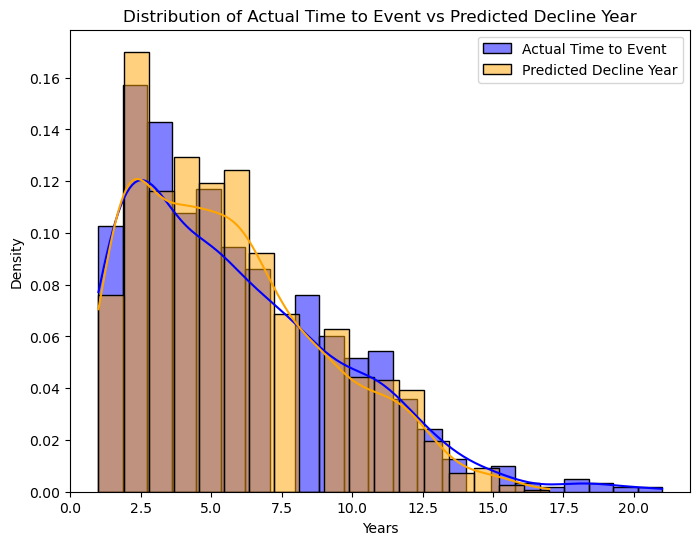

In [72]:
# Plot: Distribution of Predicted vs Actual Decline Years
plt.figure(figsize=(8, 6))
sns.histplot(valid_predictions["actual_time_to_event"], kde=True, color='blue', label='Actual Time to Event', stat='density')
sns.histplot(valid_predictions["predicted_decline_years"], kde=True, color='orange', label='Predicted Decline Year', stat='density')
plt.title("Distribution of Actual Time to Event vs Predicted Decline Year")
plt.xlabel("Years")
plt.ylabel("Density")
plt.legend()
plt.show()

## Feature Importance 

In [74]:
from sklearn.inspection import permutation_importance

# Evaluate the model on the test set
result = permutation_importance(rsf, X_test, y_test, n_repeats=10, random_state=42)

# Get the importances and sort them
importances = result.importances_mean
stds = result.importances_std

# Create a DataFrame to view the importance of each feature
importance_df = pd.DataFrame({
    'Feature': features.columns,
    'Importance': importances,
    'Std': stds
})

# Sort features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Permutation Feature Importance Ranking:")
print(importance_df)

# Select top k most important features (adjust k as needed)
k = 10  # For example, select top 10 features
top_k_features = importance_df.head(k)['Feature'].values

print(f"Top {k} features selected: {top_k_features}")

Permutation Feature Importance Ranking:
          Feature  Importance       Std
24  decline_event    0.191823  0.003946
80     RBI_cumsum    0.002595  0.000302
4              2B    0.001916  0.000281
10             BB    0.001879  0.000160
1              AB    0.001872  0.000464
..            ...         ...       ...
90      GS_cumsum   -0.001017  0.000267
83      BB_cumsum   -0.001223  0.000160
3               H   -0.001907  0.000584
2               R   -0.002005  0.000504
53  H_rolling_avg   -0.002246  0.000106

[96 rows x 3 columns]
Top 10 features selected: ['decline_event' 'RBI_cumsum' '2B' 'BB' 'AB' 'R_cumsum' 'H_diff'
 'G_cumsum' 'RBI' '2B_cumsum']
